In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 
from glob import glob
import datetime
from clsutils import *

import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

__Python VERSION: 3.7.0 (default, Oct  9 2018, 10:31:47) 
[GCC 7.3.0]
__pyTorch VERSION: 1.0.1.post2
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7402
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0
USE CUDA=True


In [12]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

to_tensor = transforms.Compose([transforms.ToTensor()])


def default_loader_scale(input_path, size=150):
    input_image = (Image.open(input_path)).convert('RGB')
    if size is not None:
        input_image = input_image.resize((size, size), Image.ANTIALIAS)
    return input_image


def default_loader(input_path):
    input_image = (Image.open(input_path)).convert('RGB')
    return input_image

class RandomErasing(object):
    def __init__(self, EPSILON = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.EPSILON = EPSILON
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.EPSILON:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.size()[2] and h <= img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    #img[0, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[1, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[2, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                    #img[:, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(3, h, w))
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[1]
                    # img[0, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(1, h, w))
                return img

        return img

# from clsmodels import *
# from clsdataset import *
# from clstransforms import *

In [3]:
class ISIC2018Dataset(Dataset):
    def __init__(self, labels, root_dir, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]  # file name
        img_name = self.labels.iloc[idx, :].loc['file']
        fullname = ''.join(['../input/ISIC2018_Task3_Training_Input/', img_name, '.jpg'])
        image = default_loader(fullname)
        labels = self.labels.iloc[idx, :].loc['category_id']
        if self.transform:
            image = self.transform(image)
        return image, labels

    @staticmethod
    def find_classes_melanoma(fullDir):

        df_labels = pd.read_csv("melanoma_labels.csv", sep=',')
        class_to_idx = {'MEL': 0,'NV' :1, 'BCC' :2 ,'AKIEC' :3, 'BKL' :4, 'DF' :5 ,'VASC' :6}
        num_to_class = {0 :'MEL',1: 'NV', 2: 'BCC' ,3: 'AKIEC', 4: 'BKL', 5: 'DF' ,6: 'VASC'}
        df_labels['category_id'] = np.argmax(df_labels.iloc[:,1:].values,axis=1)
        df_labels['category'] = [num_to_class[x] for x in df_labels['category_id']]
        #
        # classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
        classes = {'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'}

        print('Classes: {}'.format(classes))
        print('class_to_idx: {}'.format(class_to_idx))
        print('num_to_class: {}'.format(num_to_class))

        df = df_labels.loc[:,['image', 'category', 'category_id']]
        df = df.rename(columns={'image':'file'})
        df.to_csv('full_melanoma_labels.csv', index=None)
        return classes, class_to_idx, num_to_class, df


In [4]:
dataset='ISIC2018_Task3_Training_Input' # bone , cat-dog   d:/db/data/cat-dog/train/ ISIC2017 d:\db\data\IDC_regular_ps50_idx5\
data_dir= '../input/' +  dataset

Number of images: 10015
../input/ISIC2018_Task3_Training_Input/ISIC_0033207.jpg
../input/ISIC2018_Task3_Training_Input/ISIC_0024732.jpg
../input/ISIC2018_Task3_Training_Input/ISIC_0029150.jpg
../input/ISIC2018_Task3_Training_Input/ISIC_0028229.jpg
../input/ISIC2018_Task3_Training_Input/ISIC_0029938.jpg


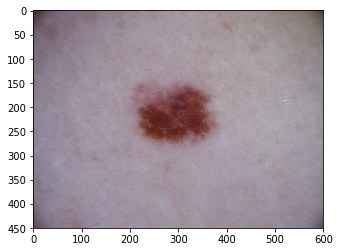

In [5]:
imageList = glob(data_dir + '/**/*.jpg', recursive=True)
print ( "Number of images: {}". format (len (imageList)))
for img in imageList[0:5]:
    print(img)
    
pil_im = Image.open(imageList[0], 'r')
plt.imshow(np.asarray(pil_im))

In [6]:
classes, class_to_idx, num_to_class, df =ISIC2018Dataset.find_classes_melanoma(data_dir)
pd.set_option('max_colwidth', 60)
print (classes)
print (class_to_idx)
print (num_to_class)
print (df.head(10))
df.category.value_counts()

Classes: {'VASC', 'BCC', 'MEL', 'AKIEC', 'BKL', 'NV', 'DF'}
class_to_idx: {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
num_to_class: {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}
{'VASC', 'BCC', 'MEL', 'AKIEC', 'BKL', 'NV', 'DF'}
{'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
{0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}
           file category  category_id
0  ISIC_0024306       NV            1
1  ISIC_0024307       NV            1
2  ISIC_0024308       NV            1
3  ISIC_0024309       NV            1
4  ISIC_0024310      MEL            0
5  ISIC_0024311       NV            1
6  ISIC_0024312      BKL            4
7  ISIC_0024313      MEL            0
8  ISIC_0024314       NV            1
9  ISIC_0024315      MEL            0


NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: category, dtype: int64

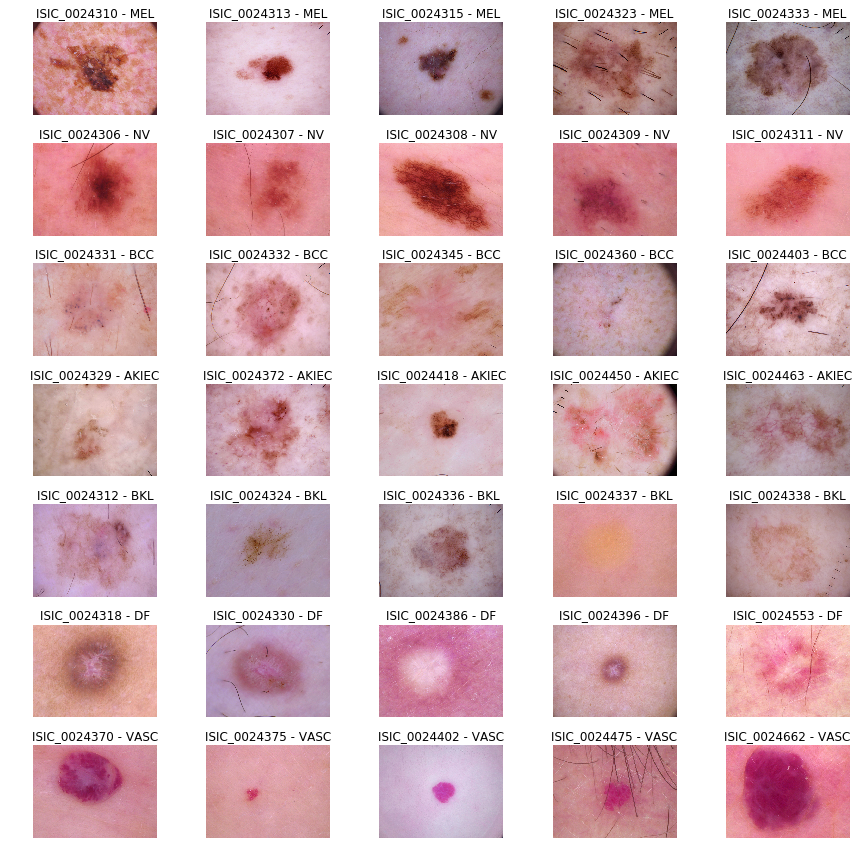

In [7]:
img_dir = '../input/ISIC2018_Task3_Training_Input/'
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
for i in range(35):
    l,c = df.loc[df.category_id==i//5,['file','category']].iloc[i%5]
    pil_im = Image.open(img_dir+l+'.jpg', 'r')        
    plt.subplot(7, 5, i+1).set_title(l + ' - ' + c)
    plt.imshow(np.asarray(pil_im)); 
    plt.axis('off')

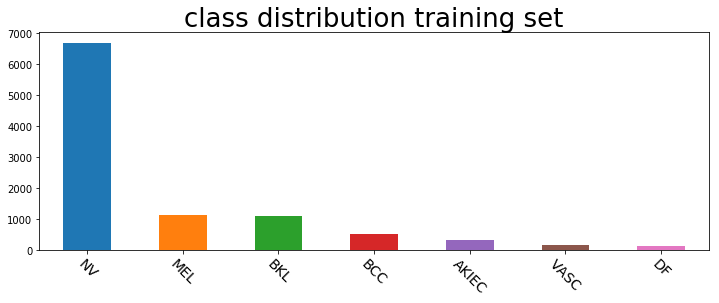

In [8]:
ax = df.category.value_counts().plot(kind='bar',figsize=(12,4))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45,fontsize=14)
_ = ax.set_title('class distribution training set',fontsize=26)

dataset sizes:
{'train': 8563, 'valid': 951, 'test': 501}


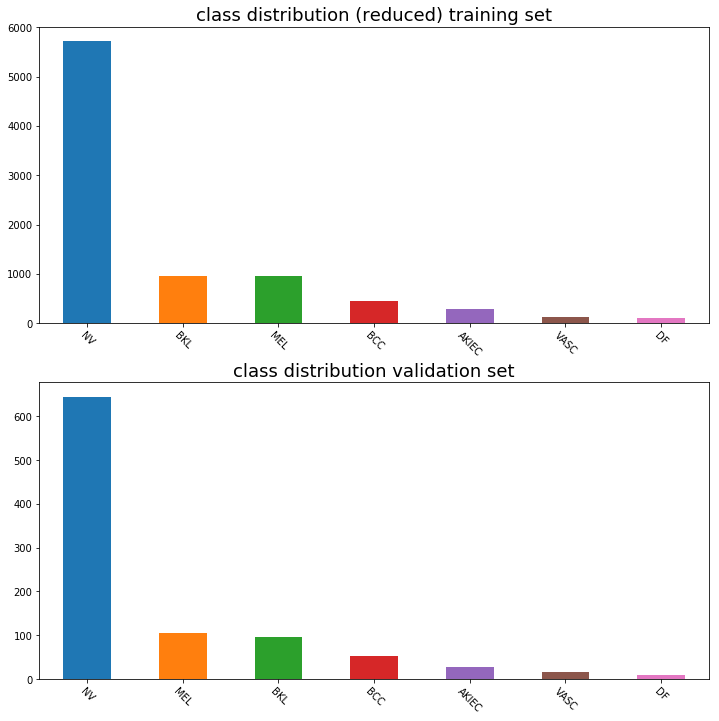

In [13]:
image_size = 224

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py
normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
#     PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
#     RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 64


full_data = df.sample(frac=0.95) # save for testing (not validation)
# full_data = full_data.sample(frac=0.10) # DATA SET IS quite large use a sample first to verify process flow

test_data = df[~df['file'].isin(full_data['file'])]
test_set = ISIC2018Dataset(test_data, data_dir, transform = valid_trans)

# Train validation split
train_data = full_data.sample(frac=0.9)
valid_data = full_data[~full_data['file'].isin(train_data['file'])]
train_set = ISIC2018Dataset(train_data, '', transform = train_trans)
valid_set = ISIC2018Dataset(valid_data, '', transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size//8, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset),
    'test': len(test_loader.dataset)
}
print ('dataset sizes:')
print (dataset_sizes)
fig,ax = plt.subplots(2,1,figsize=(12,12))
ax[0] = train_data['category'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_xticklabels(ax[0].xaxis.get_majorticklabels(), rotation=-45,fontsize=10)
_ = ax[0].set_title('class distribution (reduced) training set',fontsize=18)
ax[1] = valid_data['category'].value_counts().plot(kind='bar',ax=ax[1])
ax[1].set_xticklabels(ax[1].xaxis.get_majorticklabels(), rotation=-45,fontsize=10)
_ = ax[1].set_title('class distribution validation set',fontsize=18)

In [14]:
NOW_TIME = datetime.datetime.now()
NOW_TIME =NOW_TIME.strftime("%Y-%m-%d %H:%M")

use_tensorboard=False

hms_string(1000)

'0:16:40.00'

i=0: 
i=1: 
i=2: 
i=3: 


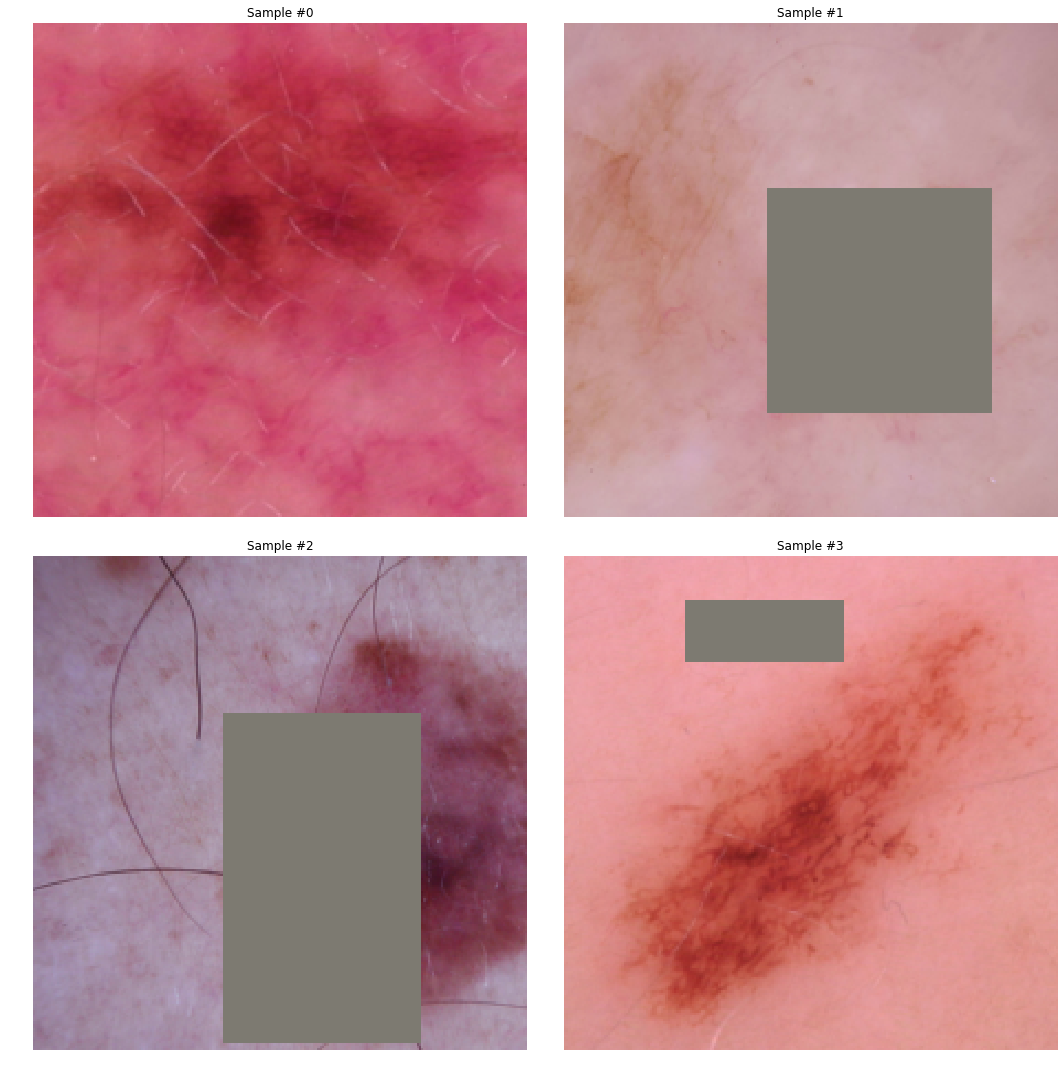

In [16]:
def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
imagesToShow=4
# plt.figure(figsize=[10,10])
for i, data in enumerate(t_loader, 0):
    print('i=%d: '%(i))            
    images, labels = data            
    num = len(images)

    ax = plt.subplot(2,2, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (flaotTensorToImage(image))

    if i==imagesToShow-1:
        break  

In [12]:
import math 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

# model = SimpleNet(len(classes), 3)
# model =vggnetXX_generic(len(classes), 3)
# model =lenetXX_generic(len(classes), 3)
# model =resnetxtXX_generic(len(classes), 3)
# model =wrnXX_generic(len(classes), 3)
# model =dpn92(len(classes))
# model = senetXX_generic(len(classes), 3, 32)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)

criterion = torch.nn.CrossEntropyLoss()
lr= 0.005 * 2 * 2
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                              weight_decay=0.0005, nesterov=True)
  

if use_cuda:
    model = model.cuda()
# model = senetXX_generic(len(classes), 3, 32)
model_name = (type(model).__name__) # remember the real name
# model = torch.nn.DataParallel(model, device_ids=list(range(4)))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [26]:
from tqdm import tqdm 
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader,0): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data.item(), images.size(0))
        acc.update(prec1.item(), images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if batch_idx % 1000  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),loss.data.item(),
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data.item(), images.size(0))
        acc.update(prec1.item(), images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 1000== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(
                loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))


def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
#             if use_cuda:
#                 X_tensor_test = Variable(X_tensor_test.cuda()) 
#             else:
#                 X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

In [14]:
if __name__ == '__main__':  
    
    epochs=5
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve2(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(0.0):            
            print ("EARLY STOP")                        
#             torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        
            torch.save(model.state_dict(),os.path.join(mPath, model_name + '_'  + str(val_accuracy) + '_' + str (epoch) + '_' + runId  + '_.pth'))
    
    

  0%|          | 0/5 [00:00<?, ?it/s]

Random Seed: 999
python version : 3.7.0 (default, Oct  9 2018, 10:31:47)  [GCC 7.3.0]
torch  version : 1.0.1.post2
cudnn  version : 7402
=> Final model name 'ResNet'
MODEL: ResNet
dataset: ISIC2018_Task3_Training_Input
    Total params: 11.18M
MODEL: ResNet
TRAIN: LOSS-->1.8862 (1.8862)	ACC-->12.500% (12.500%)
TRAIN: 0 [0/8563 (0%)]	Loss: 1.886213, Accuracy: 8/64 (12.000%)
VAL:   LOSS--> 0.7129 (0.7129)	ACC-->62.500 (62.500)
 * Accuracy 74.1325


 20%|██        | 1/5 [01:37<06:30, 97.69s/it]

EARLY STOP
TRAIN: LOSS-->0.8482 (0.8482)	ACC-->67.188% (67.188%)
TRAIN: 1 [0/8563 (0%)]	Loss: 0.848225, Accuracy: 43/64 (67.000%)
VAL:   LOSS--> 0.4405 (0.4405)	ACC-->75.000 (75.000)
 * Accuracy 77.1819


 40%|████      | 2/5 [03:15<04:52, 97.61s/it]

EARLY STOP
TRAIN: LOSS-->0.4960 (0.4960)	ACC-->84.375% (84.375%)
TRAIN: 2 [0/8563 (0%)]	Loss: 0.496050, Accuracy: 54/64 (84.000%)
VAL:   LOSS--> 0.3701 (0.3701)	ACC-->87.500 (87.500)
 * Accuracy 74.6583


 60%|██████    | 3/5 [04:52<03:15, 97.54s/it]

EARLY STOP
TRAIN: LOSS-->0.7495 (0.7495)	ACC-->71.875% (71.875%)
TRAIN: 3 [0/8563 (0%)]	Loss: 0.749504, Accuracy: 46/64 (71.000%)
VAL:   LOSS--> 0.3519 (0.3519)	ACC-->87.500 (87.500)
 * Accuracy 76.8665


 80%|████████  | 4/5 [06:30<01:37, 97.57s/it]

EARLY STOP
TRAIN: LOSS-->0.5389 (0.5389)	ACC-->82.812% (82.812%)
TRAIN: 4 [0/8563 (0%)]	Loss: 0.538935, Accuracy: 53/64 (82.000%)
VAL:   LOSS--> 0.4786 (0.4786)	ACC-->75.000 (75.000)
 * Accuracy 79.4953


100%|██████████| 5/5 [08:08<00:00, 97.67s/it]

EARLY STOP


In [18]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)

criterion = torch.nn.CrossEntropyLoss()
lr= 0.005 * 2 * 2
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                              weight_decay=0.0005, nesterov=True)
if use_cuda:
    model = model.cuda()
    
model.load_state_dict(torch.load('./logs/ISIC2018_Task3_Training_Input/ResNet/ResNet_83.070452_5_2019-05-19_06-13-35_.pth'))
model.eval()

# val_preds,val_labels = validate2(v_loader,model,1)
val_preds,val_labels=[],[]
with torch.no_grad():
    for i, (images, labels) in enumerate(v_loader):
        model.cuda()
        val_preds.append(model(images.cuda()).cpu().numpy())
        val_labels.append(labels.cpu().numpy())

              precision    recall  f1-score   support

           0       0.87      0.56      0.68       104
           1       0.91      0.99      0.95       645
           2       0.91      0.83      0.87        52
           3       0.71      0.43      0.53        28
           4       0.77      0.76      0.77        95
           5       0.83      1.00      0.91        10
           6       1.00      1.00      1.00        17

   micro avg       0.89      0.89      0.89       951
   macro avg       0.86      0.79      0.81       951
weighted avg       0.89      0.89      0.88       951



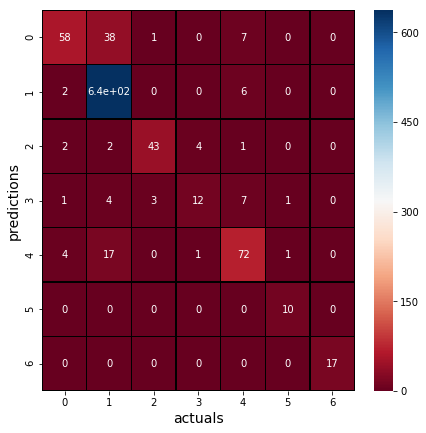

In [19]:
from sklearn.metrics import confusion_matrix,classification_report
plt.figure(figsize=(7,7))
y_true,y_pred = np.concatenate(val_labels),np.concatenate([np.argmax(val_preds[i],1) for i in range(len(val_preds))])
fig = sns.heatmap(confusion_matrix(y_true,y_pred),cmap='RdBu',annot=True,linewidths=.25,linecolor='black')
fig.set_xlabel('actuals',fontsize=14)
fig.set_ylabel('predictions',fontsize=14)

print(classification_report(y_true,y_pred))

In [ ]:
#train last layer only
#plot lime explanation of decision pixels

In [22]:
model.requires_grad = False


In [23]:
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [27]:
if __name__ == '__main__':  
    model_name = (type(model).__name__)
    epochs=5
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve2(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(0.0):            
            print ("EARLY STOP")                        
#             torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        
            torch.save(model.state_dict(),os.path.join(mPath, model_name +'update_last_layer'+ '_'  + str(val_accuracy) + '_' + str (epoch) + '_' + runId  + '_.pth'))
    
    

  0%|          | 0/5 [00:00<?, ?it/s]

Random Seed: 999
python version : 3.7.0 (default, Oct  9 2018, 10:31:47)  [GCC 7.3.0]
torch  version : 1.0.1.post2
cudnn  version : 7402
=> Final model name 'ResNet'
MODEL: ResNet
dataset: ISIC2018_Task3_Training_Input
    Total params: 11.18M
MODEL: ResNet
TRAIN: LOSS-->0.5894 (0.5894)	ACC-->75.000% (75.000%)
TRAIN: 0 [0/8563 (0%)]	Loss: 0.589359, Accuracy: 48/64 (75.000%)
VAL:   LOSS--> 0.6767 (0.6767)	ACC-->75.000 (75.000)
 * Accuracy 86.5405


 20%|██        | 1/5 [01:37<06:31, 97.82s/it]

EARLY STOP
TRAIN: LOSS-->0.4951 (0.4951)	ACC-->79.688% (79.688%)
TRAIN: 1 [0/8563 (0%)]	Loss: 0.495060, Accuracy: 51/64 (79.000%)
VAL:   LOSS--> 0.4580 (0.4580)	ACC-->87.500 (87.500)
 * Accuracy 70.0315


 40%|████      | 2/5 [03:16<04:53, 97.94s/it]

EARLY STOP
TRAIN: LOSS-->0.4056 (0.4056)	ACC-->84.375% (84.375%)
TRAIN: 2 [0/8563 (0%)]	Loss: 0.405605, Accuracy: 54/64 (84.000%)
VAL:   LOSS--> 0.0444 (0.0444)	ACC-->100.000 (100.000)
 * Accuracy 85.9096


 60%|██████    | 3/5 [04:54<03:15, 97.99s/it]

EARLY STOP
TRAIN: LOSS-->0.3243 (0.3243)	ACC-->90.625% (90.625%)
TRAIN: 3 [0/8563 (0%)]	Loss: 0.324254, Accuracy: 58/64 (90.000%)
VAL:   LOSS--> 0.1892 (0.1892)	ACC-->87.500 (87.500)
 * Accuracy 88.2229


 80%|████████  | 4/5 [06:32<01:38, 98.04s/it]

EARLY STOP
TRAIN: LOSS-->0.3510 (0.3510)	ACC-->89.062% (89.062%)
TRAIN: 4 [0/8563 (0%)]	Loss: 0.350962, Accuracy: 57/64 (89.000%)
VAL:   LOSS--> 0.0831 (0.0831)	ACC-->100.000 (100.000)
 * Accuracy 90.8517


100%|██████████| 5/5 [08:10<00:00, 97.97s/it]

EARLY STOP


In [29]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)

criterion = torch.nn.CrossEntropyLoss()
lr= 0.005 * 2 * 2
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                              weight_decay=0.0005, nesterov=True)
if use_cuda:
    model = model.cuda()
    
model.load_state_dict(torch.load('./logs/ISIC2018_Task3_Training_Input/ResNet/ResNetupdate_last_layer_90.851735_4_2019-05-19_15-09-30_.pth'))
model.eval()

# val_preds,val_labels = validate2(v_loader,model,1)
val_preds,val_labels=[],[]
with torch.no_grad():
    for i, (images, labels) in enumerate(v_loader):
        model.cuda()
        val_preds.append(model(images.cuda()).cpu().numpy())
        val_labels.append(labels.cpu().numpy())

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       104
           1       0.95      0.96      0.96       645
           2       0.85      0.85      0.85        52
           3       0.76      0.68      0.72        28
           4       0.85      0.78      0.81        95
           5       1.00      1.00      1.00        10
           6       0.81      1.00      0.89        17

   micro avg       0.91      0.91      0.91       951
   macro avg       0.86      0.86      0.86       951
weighted avg       0.91      0.91      0.91       951



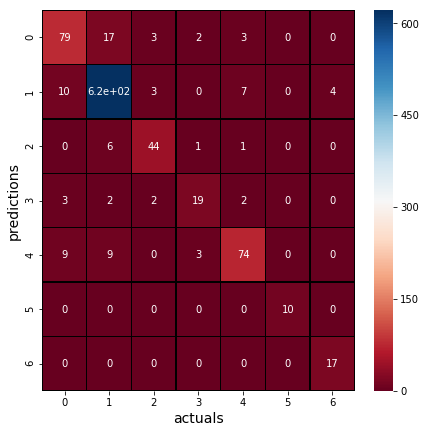

In [30]:
from sklearn.metrics import confusion_matrix,classification_report
plt.figure(figsize=(7,7))
y_true,y_pred = np.concatenate(val_labels),np.concatenate([np.argmax(val_preds[i],1) for i in range(len(val_preds))])
fig = sns.heatmap(confusion_matrix(y_true,y_pred),cmap='RdBu',annot=True,linewidths=.25,linecolor='black')
fig.set_xlabel('actuals',fontsize=14)
fig.set_ylabel('predictions',fontsize=14)

print(classification_report(y_true,y_pred))

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa

# wrapper around imgaug so it is compatible with pytorch transforms format
class ImgAugTransform:
    def __init__(self, aug):
        self.aug = aug
      
    def __call__(self, img):
        img = np.array(img)
        return Image.fromarray(np.uint8(self.aug.augment_image(img)))
  
    def __repr__(self):
        return self.__class__.__name__ + ' ' + str(self.aug)
    
class DrawShape:

    def __call__(self, img):
        draw = ImageDraw.Draw(img)
        corner = np.random.randint(1,5)
        coord = ((np.random.randint(0,img.size[0]/8) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/8 + img.size[0]/2* (corner==3 or corner==4))), 
                        (np.random.randint(0,img.size[0]/2) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/2 + img.size[0]/2* (corner==3 or corner==4))))
        if np.random.rand()<0.5:
            draw.ellipse(coord, fill=np.random.randint(0,240))
        else:
            draw.rectangle(coord, fill=np.random.randint(0,240))
        del draw
        return img
    
